## reding data:

connect to drive for accessing the dataset: (*)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data class: pars names for accessing labels, calc mean and std of data through reading data one by one to prevent RAM problems,read batches of data and partial fitting the PCA to each batch again to prevent RAM problems, reading data and saving the 128 element of the transformed vector, and seperate data to train-test-validation sets. (*)

In [3]:
import glob
import cv2
from matplotlib import pyplot as plt
import numpy as np
class Data:
    def __init__(self, file_name, partial_read = True):
        self.file_names = glob.glob(file_name)
        self.file_names_all = np.copy(self.file_names)
        if partial_read:
            self.file_names = np.random.choice(self.file_names,int(len(self.file_names)/10))
        self.partial_read = partial_read
        self.labels = []
        self.imgs = []
        self.test_imgs = []
        self.train_imgs = []
        self.valid_imgs = []
        self.test_labels = []
        self.train_labels = []
        self.valid_labels = []
        self.img_shape = []
        self.m = 0
        self.std = 0
    def pars_name(self):
        for n in self.file_names:
            self.labels.append(n.split('/')[-1].split('.jpg')[0])
    def get_mean(self):
        size = len(cv2.imread(self.file_names_all[0]).flatten())
        m = np.zeros(size)
        for n in self.file_names_all:
            img = cv2.imread(n).flatten()
            m = m + img
        m = m/size
        return m
    def get_std(self,m):
        size = len(cv2.imread(self.file_names_all[0]).flatten())
        std = np.zeros(size)
        for n in self.file_names_all:
            img = cv2.imread(n).flatten()
            std = std + (img-m)*(img-m)
        std = std/(size-1)
        return np.sqrt(std)
    def partial_fitting(self, transformer,m,std):
        i = 0
        while i < len(self.file_names_all ):
            file_names = self.file_names_all [i:i+int(len(self.file_names_all)/20)]
            imgs = []
            for n in file_names:
                img = cv2.imread(n).flatten()
                imgs.append((img-m)/std)
            #print(np.shape(imgs))
            if len(imgs)<128:
                break
            transformer.fit(imgs)
            i = i + int(len(self.file_names_all)/20)
        return transformer

    def read_imgs(self, transformer = None):
        for n in self.file_names:
            img = cv2.imread(n)
            self.img_shape = np.shape(img)
            #m = np.mean(img)
            #std = np.std(img)
            #img = ((img-m)/std).flatten()
            img = img.flatten()
            if self.partial_read:
                self.imgs.append(img)
            else:
                self.imgs.append(transformer.transform(((img-self.m)/self.std).reshape(1, -1)))
        if self.partial_read:
            self.m = np.mean(self.imgs,axis = 0)
            self.std = np.std(self.imgs,axis = 0)
            for i in range(len(self.imgs)):
                self.imgs[i] = ((self.imgs[i]-self.m)/self.std)
        return self.m, self.std
    
    def save_to_file(self):
        return
    def read_from_file(self):
        return
    def seperate_data(self,test_size):
        self.imgs = (self.imgs-np.mean(self.imgs,axis=0))/np.std(self.imgs,axis=0)
        index = [i for i in range(len(self.imgs))]
        test_index = np.random.choice(index,test_size*2)
        val_index = test_index[0:test_size]
        test_index = test_index[test_size:-1]
        for i in range(len(self.imgs)):
            if i in test_index:
                self.test_imgs.append(self.imgs[i])
                self.test_labels.append(self.labels[i])
            elif i in val_index:
                self.valid_imgs.append(self.imgs[i])
                self.valid_labels.append(self.labels[i])
            else:
                self.train_imgs.append(self.imgs[i])
                self.train_labels.append(self.labels[i])
        del self.imgs
        del self.labels

calculate the mean:
  * enter the file address

In [ ]:
data = Data('./drive/MyDrive/UTKFacezip/UTKFace/*.jpg')
data.pars_name()
m = data.get_mean()

In [ ]:
print(m)

[15.87138333 17.55668333 19.89168333 15.71406667 17.4175     19.744425
 15.554825   17.23794167 19.636425   15.37819167 17.10813333 19.49129167
 15.23278333 16.92961667 19.437075   15.05196667 16.82470833 19.32491667
 14.92051667 16.663975   19.32974167 14.746575   16.5812     19.25093333
 14.655825   16.46503333 19.32054167 14.50986667 16.42201667 19.29315833
 14.446225   16.33305833 19.40781667 14.34711667 16.3289     19.42378333
 14.28993333 16.25780833 19.52655833 14.265025   16.29766667 19.57191667
 14.305375   16.32973333 19.72401667 14.22208333 16.37540833 19.79750833
 14.259725   16.37525    20.07986667 14.20718333 16.45615    20.19073333
 14.30825    16.558075   20.42658333 14.38239167 16.71006667 20.59331667
 14.466025   16.79000833 20.88756667 14.52425833 16.9723     21.11593333
 14.66474167 17.117375   21.5313     14.68508333 17.28619167 21.76508333
 14.82918333 17.43541667 22.20101667 14.84959167 17.6116     22.44729167
 15.04390833 17.815175   22.94029167 15.17591667 18.0

calculating the std:
  * enter the file address

In [ ]:
data = Data('./drive/MyDrive/UTKFacezip/UTKFace/*.jpg')
data.pars_name()
std = data.get_std(m)
print(std)

[42.73555353 45.16648476 48.84758597 42.31134899 44.78761008 48.49884706
 41.91669221 44.39678986 48.26732479 41.46315862 44.03985995 47.94823967
 41.06272363 43.63109747 47.76610107 40.61616427 43.31967058 47.50513917
 40.15326201 42.85925693 47.35013765 39.73080236 42.59247017 47.14689722
 39.4076634  42.28098951 47.16900321 39.01676557 42.05160695 47.03199538
 38.76417883 41.80508012 47.14478513 38.44324916 41.63735203 47.08435431
 38.18750972 41.401253   47.15979109 37.98699739 41.32589308 47.1724077
 37.81238442 41.18485241 47.29832973 37.55172626 41.12735529 47.35805054
 37.45947026 41.0175826  47.75380888 37.20753899 40.96572704 47.84278469
 37.21197489 41.00497391 48.15636553 37.17209114 41.09671456 48.36442506
 37.18205456 41.12693846 48.76111928 37.1782004  41.30017975 49.08974701
 37.20892508 41.37661386 49.64341388 37.16756436 41.53698415 49.96536197
 37.26777181 41.67623901 50.58737827 37.1943446  41.80384439 50.86957621
 37.38284118 42.03267195 51.5685597  37.49028873 42.

fit PCA to each batch of data

In [ ]:
from sklearn.decomposition import IncrementalPCA
transformer = IncrementalPCA(n_components=128, batch_size=200)
transformer = data.partial_fitting(transformer,m,std)

Read data, save the transformed data and save the transformed data in a file for faster future reading:
  * enter the file address and destination

In [ ]:
data = Data('./drive/MyDrive/UTKFacezip/UTKFace/*.jpg',False)
data.m = m
data.std = std
data.pars_name()
data.read_imgs(transformer)
# data.seperate_data(2000)
with open('./drive/MyDrive/UTKFacezip/transformed.txt', 'w') as writefile:
  for i in range(len(data.labels)):
    x = ''
    for pixle in data.imgs[i]:
        x = x + str(pixle) + ','
    x = x + data.labels[i]
    writefile.write(x)
data.imgs = np.reshape(data.imgs,(len(data.imgs),128))

Reading re-transformed data: (*)
  * enter the file address


In [4]:
data = Data('./drive/MyDrive/UTKFacezip/UTKFace/*.jpgg',False)
with open('./drive/MyDrive/UTKFacezip/transformed.txt', 'r') as testwritefile:
    #print(np.array(testwritefile.read().replace('\n','').replace("  "," ").split("[")[1:-1][0][1:-1].split("],")[0].split(" ")).astype(float))
    data.labels = []
    data.imgs = []
    for x in testwritefile.read().replace('\n','').replace("  "," ").replace("  "," ").replace("  "," ").replace(" ],","],").split("[")[1:-1]:
        x = x[1:-1]
        y = x.split("],")[1] 
        #print(y)
        x = x.split("],")[0].split(" ")
        if len(x)!=128:
            temp = []
            for i in x:
                if i!="":
                    temp.append(i)
            x = temp
        img = np.array(x).astype(float)
        data.labels.append(np.array(y.split("_")[0:len(y.split("_"))-1]).astype(int))
        temp = [x for x in img]
        data.imgs.append(temp)

seperating the data:(*)

In [5]:
data.seperate_data(2000)

### Part A

Set the goal label:

In [12]:
train_label = [int(l[0]) for l in data.train_labels]
valid_label = [int(l[0]) for l in data.valid_labels]
test_label = [int(l[0]) for l in data.test_labels]

  * set network architecture
  * creat mini batches
  * train for n epochs
    * in each epoch each batch of data is forwardded and the trained (backward step) through layers.
  * calculate RMSE of test dat

Zero Weight initialization:

In [98]:
def creat_minibatch(data,label,batch_size):
    #print(np.shape(data))
    #print(np.shape(label))
    merged = np.c_[ data, label ] 
    np.random.shuffle(merged)
    #print(np.shape(merged))
    batchX = []
    batchy = []
    i = 0
    while i < len(merged):
        x = merged[i:i+batch_size,0:len(merged[0])-1]
        y = merged[i:i+batch_size,-1]
        batchX.append(x)
        batchy.append(y)
        i = i + batch_size
    #print(batchX)
    #print(batchy)
    return batchX, batchy
#creat_minibatch([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]],[1,2,3,4,5,6,7,8],4)

class LReLU():
    def __init__(self):
        return
    
    def forward(self,Z): #input, output = [batch,neuroncount]
        return np.array(Z>=0).astype(int) * Z + np.array(Z<0).astype(int) * Z * 0.01
    def backward(self,Z,dz):
        return np.array(Z>=0).astype(int)*dz + np.array(Z<0).astype(int) * 0.01 * dz
    
class Dense():
    def __init__(self,input,neuron,lr):
        self.neuroncount = neuron
        self.inputcount = input
        self.lr = lr
        self.W =  np.random.randn(input,neuron)
        self.W = np.random.normal(loc=0.0,scale=np.sqrt(2/(input+neuron)),size=(input,neuron))
        self.W = np.zeros((input,neuron))
        self.b = np.zeros(neuron).astype(float)#(batch_size,neuron)
        self.delta_w = 0
    
    def forward(self,X):#X=(inputcount,batch)
        return np.dot(X,self.W) + self.b
    def backward(self,X,din):
        W = np.copy(self.W)
        #print(np.shape(X))
        #print(np.shape(gradiant))
        dw = np.dot(X.T, din.astype(float))
        self.W = self.W - self.lr * dw + 0.9*self.delta_w
        self.delta_w = - self.lr * dw + 0.9*self.delta_w
        db = np.sum(din,axis = 0)
        self.b = self.b - self.lr * db
        return np.dot(din, W.T)

class costFunction:
    def __init__(self):
        return
    def L2(self,yp,y):
        m = len(y)
        return np.sum(((np.array(yp)-np.array(y.reshape((len(y),1))))*(np.array(yp)-np.array(y.reshape((len(y),1))))),axis = 1,keepdims=True)/m/2#np.ones(ans.shape)
    def dloss(self,yp,y):
        m = len(y)
        return np.sum(np.array(yp)-np.array(y.reshape((len(y),1))),axis = 1, keepdims=True)/m#np.ones(ans.shape)
class Network:
    def __init__(self):
        self.net = []
    def add_Dense(self, shape,lr):
        self.net.append(Dense(shape[0],shape[1],lr))
    def add_LReLU(self):
        self.net.append(LReLU())
    def predict(self,X):
        out = np.copy(X)
        for layer in self.net:
            out = layer.forward(out)
        return out
    def train(self,X,y):
        cf = costFunction()
        inputs = []
        inputs.append(X)
        input = np.copy(X)
        for l in self.net:
            input = l.forward(input)
            inputs.append(input)
        yp = input
        
        loss = cf.L2(yp,y)
        dloss = cf.dloss(yp,y)

        for i in range(len(self.net)):
            j = len(self.net) - i - 1
            layer = self.net[j]       
            dloss = layer.backward(inputs[j],dloss)
        return np.mean(loss)


network = Network()
network.add_Dense((128,10),0.001)
network.add_LReLU()
network.add_Dense((10,10),0.001)
network.add_LReLU()
network.add_Dense((10,10),0.001)
network.add_LReLU()
network.add_Dense((10,1),0.001)
network.add_LReLU()
batch_size = 128
loss_Total = []
Train_loss = []
valid_loss = []
cf = costFunction()
Train_loss.append(np.mean(cf.L2(network.predict(data.train_imgs),np.array(train_label))))
valid_loss.append(np.mean(cf.L2(network.predict(data.valid_imgs),np.array(valid_label))))
for epoch in range(100):
    batchX, batchy = creat_minibatch(data.train_imgs,train_label,batch_size)#diabetes_X,diabetes_y
    l1 = []
    l2 = []
    i = 0
    for (x_batch,y_batch) in zip(batchX, batchy):
        if np.shape(x_batch)[0] != batch_size:
            break
        loss_Total.append(network.train(np.array(x_batch).astype(float),y_batch))
        if i % 10 == 1:
            l1.append(np.mean(cf.L2(network.predict(data.train_imgs),np.array(train_label))))
            l2.append(np.mean(cf.L2(network.predict(data.valid_imgs),np.array(valid_label))))
        i = i + 1
        print(loss_Total[-1])
    for l in [0,2,4,6]:
        if network.net[l].lr > 0.0001:
            network.net[l].lr = network.net[l].lr - 0.0001
    print(epoch)   
    Train_loss.append(np.mean(l1))
    valid_loss.append(np.mean(l2))
print("Test RMSE:")
print(np.sqrt(np.mean((network.predict(data.test_imgs)-test_label)**2)))

Streaming output truncated to the last 5000 lines.
1.3294954690464167
1.6407221820200983
1.2026708116961733
2.3136062167477878
1.6565171256736095
1.6983400170107077
2.1501453105969492
1.7315961465104968
1.546312989311532
1.6505625466807994
1.4367985926489986
1.3766457028218135
1.7816644725454287
1.8817942882815533
1.3437717822938133
1.4232528471467563
1.7008420258744112
1.660198089048602
1.7353182010382366
1.717778678879607
1.7462482244966981
1.7918688366168223
1.2977734754890606
1.9572357395595539
1.7552970736504727
1.6582456481657901
1.84040748560028
1.8609554114186635
1.633678698018718
1.7249183165402275
1.6702035504065358
1.7540883065264858
1.7623761091020849
2.109480943416961
1.5454427351865847
1.2061227589855443
1.7590121040024114
1.4756975382441562
1.9059403767464465
1.4952321453503505
1.9840313072519067
1.6610569671031228
1.810029119308095
1.5870692879135941
1.9315336183305403
1.438935069161765
1.9991933927886805
1.5177808975310292
1.4439299808636146
1.3116116705232188
1.644047

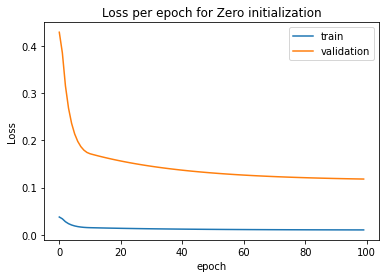

In [99]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(100)],[np.mean(Train_loss[i:i+1]) for i in range(100)],label="train")
plt.plot([i for i in range(100)],[np.mean(valid_loss[i:i+1]) for i in range(100)],label="validation")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch for Zero initialization")
plt.legend()
plt.show()

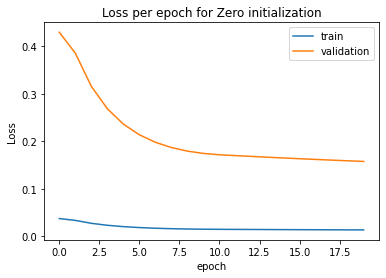

In [100]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(20)],[np.mean(Train_loss[i:i+1]) for i in range(20)],label="train")
plt.plot([i for i in range(20)],[np.mean(valid_loss[i:i+1]) for i in range(20)],label="validation")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch for Zero initialization")
plt.legend()
plt.show()

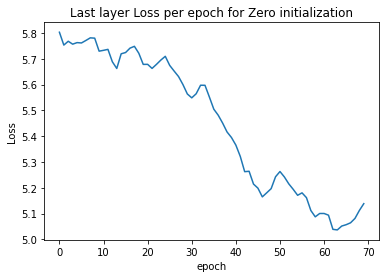

In [101]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(70)],[np.mean(loss_Total[i:i+30]) for i in range(70)])
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Last layer Loss per epoch for Zero initialization")
plt.show()

Xavier Weight initialization:

In [102]:
def creat_minibatch(data,label,batch_size):
    #print(np.shape(data))
    #print(np.shape(label))
    merged = np.c_[ data, label ] 
    np.random.shuffle(merged)
    #print(np.shape(merged))
    batchX = []
    batchy = []
    i = 0
    while i < len(merged):
        x = merged[i:i+batch_size,0:len(merged[0])-1]
        y = merged[i:i+batch_size,-1]
        batchX.append(x)
        batchy.append(y)
        i = i + batch_size
    #print(batchX)
    #print(batchy)
    return batchX, batchy
#creat_minibatch([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]],[1,2,3,4,5,6,7,8],4)

class LReLU():
    def __init__(self):
        return
    
    def forward(self,Z): #input, output = [batch,neuroncount]
        return np.array(Z>=0).astype(int) * Z + np.array(Z<0).astype(int) * Z * 0.01
    def backward(self,Z,dz):
        return np.array(Z>=0).astype(int)*dz + np.array(Z<0).astype(int) * 0.01 * dz
    
class Dense():
    def __init__(self,input,neuron,lr):
        self.neuroncount = neuron
        self.inputcount = input
        self.lr = lr
        self.W =  np.random.randn(input,neuron)
        self.W = np.random.normal(loc=0.0,scale=np.sqrt(2/(input+neuron)),size=(input,neuron))
        #self.W = np.zeros((input,neuron))
        self.b = np.zeros(neuron).astype(float)#(batch_size,neuron)
        self.delta_w = 0
    
    def forward(self,X):#X=(inputcount,batch)
        return np.dot(X,self.W) + self.b
    def backward(self,X,din):
        W = np.copy(self.W)
        #print(np.shape(X))
        #print(np.shape(gradiant))
        dw = np.dot(X.T, din.astype(float))
        self.W = self.W - self.lr * dw + 0.9*self.delta_w
        self.delta_w = - self.lr * dw + 0.9*self.delta_w
        db = np.sum(din,axis = 0)
        self.b = self.b - self.lr * db
        return np.dot(din, W.T)

class costFunction:
    def __init__(self):
        return
    def L2(self,yp,y):
        m = len(y)
        return np.sum(((np.array(yp)-np.array(y.reshape((len(y),1))))*(np.array(yp)-np.array(y.reshape((len(y),1))))),axis = 1,keepdims=True)/m/2#np.ones(ans.shape)
    def dloss(self,yp,y):
        m = len(y)
        return np.sum(np.array(yp)-np.array(y.reshape((len(y),1))),axis = 1, keepdims=True)/m#np.ones(ans.shape)
class Network:
    def __init__(self):
        self.net = []
    def add_Dense(self, shape,lr):
        self.net.append(Dense(shape[0],shape[1],lr))
    def add_LReLU(self):
        self.net.append(LReLU())
    def predict(self,X):
        out = np.copy(X)
        for layer in self.net:
            out = layer.forward(out)
        return out
    def train(self,X,y):
        cf = costFunction()
        inputs = []
        inputs.append(X)
        input = np.copy(X)
        for l in self.net:
            input = l.forward(input)
            inputs.append(input)
        yp = input
        
        loss = cf.L2(yp,y)
        dloss = cf.dloss(yp,y)

        for i in range(len(self.net)):
            j = len(self.net) - i - 1
            layer = self.net[j]       
            dloss = layer.backward(inputs[j],dloss)
        return np.mean(loss)


network = Network()
network.add_Dense((128,10),0.001)
network.add_LReLU()
network.add_Dense((10,10),0.001)
network.add_LReLU()
network.add_Dense((10,10),0.001)
network.add_LReLU()
network.add_Dense((10,1),0.001)
network.add_LReLU()
batch_size = 128
loss_Total = []
Train_loss = []
valid_loss = []
cf = costFunction()
Train_loss.append(np.mean(cf.L2(network.predict(data.train_imgs),np.array(train_label))))
valid_loss.append(np.mean(cf.L2(network.predict(data.valid_imgs),np.array(valid_label))))
for epoch in range(100):
    batchX, batchy = creat_minibatch(data.train_imgs,train_label,batch_size)#diabetes_X,diabetes_y
    l1 = []
    l2 = []
    i = 0
    for (x_batch,y_batch) in zip(batchX, batchy):
        if np.shape(x_batch)[0] != batch_size:
            break
        loss_Total.append(network.train(np.array(x_batch).astype(float),y_batch))
        if i % 10 == 1:
            l1.append(np.mean(cf.L2(network.predict(data.train_imgs),np.array(train_label))))
            l2.append(np.mean(cf.L2(network.predict(data.valid_imgs),np.array(valid_label))))
        i = i + 1
        print(loss_Total[-1])
    for l in [0,2,4,6]:
        if network.net[l].lr > 0.0001:
            network.net[l].lr = network.net[l].lr - 0.0001
    print(epoch)   
    Train_loss.append(np.mean(l1))
    valid_loss.append(np.mean(l2))
print("Test RMSE:")
print(np.sqrt(np.mean((network.predict(data.test_imgs)-test_label)**2)))

Streaming output truncated to the last 5000 lines.
0.6698906109620236
0.6040035940290693
0.6397691418640918
0.7004651817050943
0.46053738290870117
0.5227500169837046
0.6231537519196914
0.614968881474641
0.49199560451969426
1.0425843907054897
0.8012566931899093
0.5347057523792631
0.7242600836513429
0.7852272687103334
0.7535354426031093
0.7837597603463486
0.6625511241598795
0.5175492294603521
0.5565529835675643
0.7044951648805884
0.665961075472461
0.758788384079129
0.7128899490866587
0.6509519804098888
0.6764795216849957
0.5392399261541964
0.634873597025601
0.5213654982388023
0.720662736349954
0.6620638032079803
0.5244491609629156
0.8265392328763682
0.653394506766817
0.6496091835618771
0.7889961900047059
0.6463812040263277
0.7580463299738454
0.8401430757732906
0.6190120973168166
0.5165532567386187
0.7356871298831988
0.8777012904982251
0.6016473581268487
0.664633101553332
0.5237321387306192
0.6296399985557883
0.8155088691000099
0.7461645786532247
0.7443796675322767
0.8450031824455799
0.62

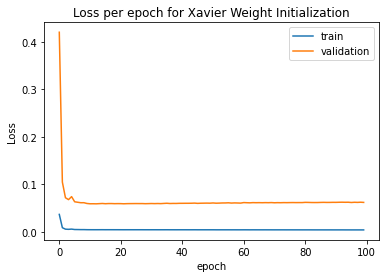

In [103]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(100)],[np.mean(Train_loss[i:i+1]) for i in range(100)],label="train")
plt.plot([i for i in range(100)],[np.mean(valid_loss[i:i+1]) for i in range(100)],label="validation")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch for Xavier Weight Initialization")
plt.legend()
plt.show()

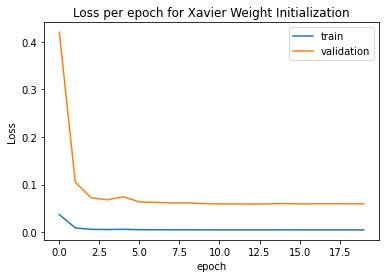

In [104]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(20)],[np.mean(Train_loss[i:i+1]) for i in range(20)],label="train")
plt.plot([i for i in range(20)],[np.mean(valid_loss[i:i+1]) for i in range(20)],label="validation")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch for Xavier Weight Initialization")
plt.legend()
plt.show()

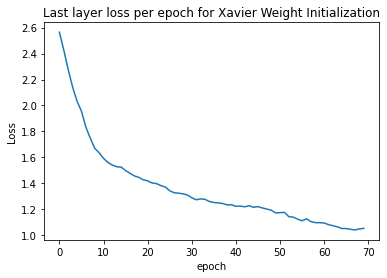

In [105]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(70)],[np.mean(loss_Total[i:i+30]) for i in range(70)])
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Last layer loss per epoch for Xavier Weight Initialization")
plt.show()

-0.1 to 0.1 random Weight Initialization

In [106]:
def creat_minibatch(data,label,batch_size):
    #print(np.shape(data))
    #print(np.shape(label))
    merged = np.c_[ data, label ] 
    np.random.shuffle(merged)
    #print(np.shape(merged))
    batchX = []
    batchy = []
    i = 0
    while i < len(merged):
        x = merged[i:i+batch_size,0:len(merged[0])-1]
        y = merged[i:i+batch_size,-1]
        batchX.append(x)
        batchy.append(y)
        i = i + batch_size
    #print(batchX)
    #print(batchy)
    return batchX, batchy
#creat_minibatch([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]],[1,2,3,4,5,6,7,8],4)

class LReLU():
    def __init__(self):
        return
    
    def forward(self,Z): #input, output = [batch,neuroncount]
        return np.array(Z>=0).astype(int) * Z + np.array(Z<0).astype(int) * Z * 0.01
    def backward(self,Z,dz):
        return np.array(Z>=0).astype(int)*dz + np.array(Z<0).astype(int) * 0.01 * dz
    
class Dense():
    def __init__(self,input,neuron,lr):
        self.neuroncount = neuron
        self.inputcount = input
        self.lr = lr
        #self.W =  np.random.randn(input,neuron)
        #self.W = np.random.normal(loc=0.0,scale=np.sqrt(2/(input+neuron)),size=(input,neuron))
        #self.W = np.zeros((input,neuron))
        self.b = np.zeros(neuron).astype(float)#(batch_size,neuron)
        self.W =  np.random.uniform(low=-0.1, high=0.1, size=(input,neuron))
        self.delta_w = 0
    
    def forward(self,X):#X=(inputcount,batch)
        return np.dot(X,self.W) + self.b
    def backward(self,X,din):
        W = np.copy(self.W)
        #print(np.shape(X))
        #print(np.shape(gradiant))
        dw = np.dot(X.T, din.astype(float))
        self.W = self.W - self.lr * dw + 0.9*self.delta_w
        self.delta_w = - self.lr * dw + 0.9*self.delta_w
        db = np.sum(din,axis = 0)
        self.b = self.b - self.lr * db
        return np.dot(din, W.T)

class costFunction:
    def __init__(self):
        return
    def L2(self,yp,y):
        m = len(y)
        return np.sum(((np.array(yp)-np.array(y.reshape((len(y),1))))*(np.array(yp)-np.array(y.reshape((len(y),1))))),axis = 1,keepdims=True)/m/2#np.ones(ans.shape)
    def dloss(self,yp,y):
        m = len(y)
        return np.sum(np.array(yp)-np.array(y.reshape((len(y),1))),axis = 1, keepdims=True)/m#np.ones(ans.shape)
class Network:
    def __init__(self):
        self.net = []
    def add_Dense(self, shape,lr):
        self.net.append(Dense(shape[0],shape[1],lr))
    def add_LReLU(self):
        self.net.append(LReLU())
    def predict(self,X):
        out = np.copy(X)
        for layer in self.net:
            out = layer.forward(out)
        return out
    def train(self,X,y):
        cf = costFunction()
        inputs = []
        inputs.append(X)
        input = np.copy(X)
        for l in self.net:
            input = l.forward(input)
            inputs.append(input)
        yp = input
        
        loss = cf.L2(yp,y)
        dloss = cf.dloss(yp,y)

        for i in range(len(self.net)):
            j = len(self.net) - i - 1
            layer = self.net[j]       
            dloss = layer.backward(inputs[j],dloss)
        return np.mean(loss)


network = Network()
network.add_Dense((128,10),0.001)
network.add_LReLU()
network.add_Dense((10,10),0.001)
network.add_LReLU()
network.add_Dense((10,10),0.001)
network.add_LReLU()
network.add_Dense((10,1),0.001)
network.add_LReLU()
batch_size = 128
loss_Total = []
Train_loss = []
valid_loss = []
cf = costFunction()
Train_loss.append(np.mean(cf.L2(network.predict(data.train_imgs),np.array(train_label))))
valid_loss.append(np.mean(cf.L2(network.predict(data.valid_imgs),np.array(valid_label))))
for epoch in range(100):
    batchX, batchy = creat_minibatch(data.train_imgs,train_label,batch_size)#diabetes_X,diabetes_y
    l1 = []
    l2 = []
    i = 0
    for (x_batch,y_batch) in zip(batchX, batchy):
        if np.shape(x_batch)[0] != batch_size:
            break
        loss_Total.append(network.train(np.array(x_batch).astype(float),y_batch))
        if i % 10 == 1:
            l1.append(np.mean(cf.L2(network.predict(data.train_imgs),np.array(train_label))))
            l2.append(np.mean(cf.L2(network.predict(data.valid_imgs),np.array(valid_label))))
        i = i + 1
        print(loss_Total[-1])
    for l in [0,2,4,6]:
        if network.net[l].lr > 0.0001:
            network.net[l].lr = network.net[l].lr - 0.0001
    print(epoch)   
    Train_loss.append(np.mean(l1))
    valid_loss.append(np.mean(l2))
print("Test RMSE:")
print(np.sqrt(np.mean((network.predict(data.test_imgs)-test_label)**2)))

Streaming output truncated to the last 5000 lines.
0.7667760990215695
1.0108255050467787
0.6731417709122822
0.6956539990959039
0.6783204107197717
0.7037360464381806
0.7084766441282002
0.9260213061399681
0.566055249148554
0.8681169150595781
0.9095577245296368
0.7588289089027834
0.476983238847793
0.8466362453797343
0.9514082552500094
0.8158170796702724
0.7284860799310697
0.6094427514825864
0.5146187526592176
0.6200450963744397
0.5605156503164355
0.9837672111155846
0.5856270588939134
0.705529201091116
0.6433397112462809
0.5907873772154641
0.7244131104963563
0.55150432534698
0.7723791129412334
0.8055591323097013
0.6248146528759846
0.6314295201829011
0.7008651361651675
0.6353131391276614
0.5556261109494243
0.5967355672730521
0.7473036176899435
0.6972944158735691
0.9099684492908903
0.6983962638086358
0.7471970439643743
0.7298866963546135
0.6929371050809152
0.6963624014920974
0.8016027429346864
0.5677321035863971
0.5372711981558291
0.6021161810512733
0.5532036141338221
0.6723811939276083
0.72

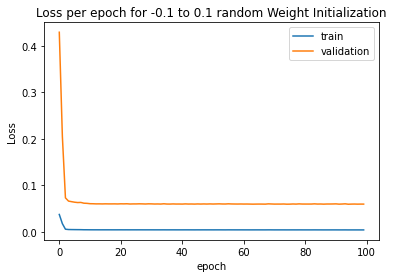

In [107]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(100)],[np.mean(Train_loss[i:i+1]) for i in range(100)],label="train")
plt.plot([i for i in range(100)],[np.mean(valid_loss[i:i+1]) for i in range(100)],label="validation")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch for -0.1 to 0.1 random Weight Initialization")
plt.legend()
plt.show()

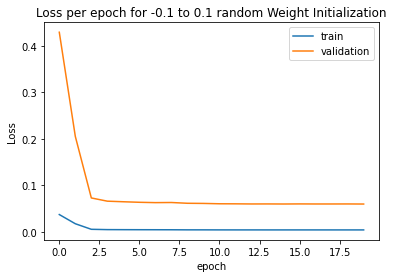

In [108]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(20)],[np.mean(Train_loss[i:i+1]) for i in range(20)],label="train")
plt.plot([i for i in range(20)],[np.mean(valid_loss[i:i+1]) for i in range(20)],label="validation")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch for -0.1 to 0.1 random Weight Initialization")
plt.legend()
plt.show()

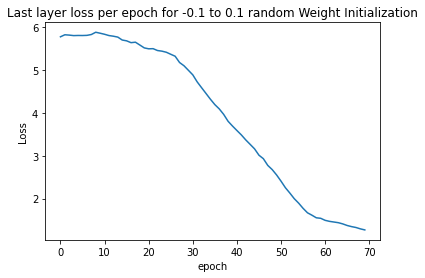

In [109]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(70)],[np.mean(loss_Total[i:i+30]) for i in range(70)])
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Last layer loss per epoch for -0.1 to 0.1 random Weight Initialization")
plt.show()

-1 to 1 random Weight Initialization:

In [110]:
def creat_minibatch(data,label,batch_size):
    #print(np.shape(data))
    #print(np.shape(label))
    merged = np.c_[ data, label ] 
    np.random.shuffle(merged)
    #print(np.shape(merged))
    batchX = []
    batchy = []
    i = 0
    while i < len(merged):
        x = merged[i:i+batch_size,0:len(merged[0])-1]
        y = merged[i:i+batch_size,-1]
        batchX.append(x)
        batchy.append(y)
        i = i + batch_size
    #print(batchX)
    #print(batchy)
    return batchX, batchy
#creat_minibatch([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]],[1,2,3,4,5,6,7,8],4)

class LReLU():
    def __init__(self):
        return
    
    def forward(self,Z): #input, output = [batch,neuroncount]
        return np.array(Z>=0).astype(int) * Z + np.array(Z<0).astype(int) * Z * 0.01
    def backward(self,Z,dz):
        return np.array(Z>=0).astype(int)*dz + np.array(Z<0).astype(int) * 0.01 * dz
    
class Dense():
    def __init__(self,input,neuron,lr):
        self.neuroncount = neuron
        self.inputcount = input
        self.lr = lr
        #self.W =  np.random.randn(input,neuron)
        #self.W = np.random.normal(loc=0.0,scale=np.sqrt(2/(input+neuron)),size=(input,neuron))
        #self.W = np.zeros((input,neuron))
        self.b = np.zeros(neuron).astype(float)#(batch_size,neuron)
        self.W =  np.random.uniform(low=-1, high=1, size=(input,neuron))
        self.delta_w = 0
    
    def forward(self,X):#X=(inputcount,batch)
        return np.dot(X,self.W) + self.b
    def backward(self,X,din):
        W = np.copy(self.W)
        #print(np.shape(X))
        #print(np.shape(gradiant))
        dw = np.dot(X.T, din.astype(float))
        self.W = self.W - self.lr * dw + 0.9*self.delta_w
        self.delta_w = - self.lr * dw + 0.9*self.delta_w
        db = np.sum(din,axis = 0)
        self.b = self.b - self.lr * db
        return np.dot(din, W.T)

class costFunction:
    def __init__(self):
        return
    def L2(self,yp,y):
        m = len(y)
        return np.sum(((np.array(yp)-np.array(y.reshape((len(y),1))))*(np.array(yp)-np.array(y.reshape((len(y),1))))),axis = 1,keepdims=True)/m/2#np.ones(ans.shape)
    def dloss(self,yp,y):
        m = len(y)
        return np.sum(np.array(yp)-np.array(y.reshape((len(y),1))),axis = 1, keepdims=True)/m#np.ones(ans.shape)
class Network:
    def __init__(self):
        self.net = []
    def add_Dense(self, shape,lr):
        self.net.append(Dense(shape[0],shape[1],lr))
    def add_LReLU(self):
        self.net.append(LReLU())
    def predict(self,X):
        out = np.copy(X)
        for layer in self.net:
            out = layer.forward(out)
        return out
    def train(self,X,y):
        cf = costFunction()
        inputs = []
        inputs.append(X)
        input = np.copy(X)
        for l in self.net:
            input = l.forward(input)
            inputs.append(input)
        yp = input
        
        loss = cf.L2(yp,y)
        dloss = cf.dloss(yp,y)

        for i in range(len(self.net)):
            j = len(self.net) - i - 1
            layer = self.net[j]       
            dloss = layer.backward(inputs[j],dloss)
        return np.mean(loss)


network = Network()
network.add_Dense((128,10),0.001)
network.add_LReLU()
network.add_Dense((10,10),0.001)
network.add_LReLU()
network.add_Dense((10,10),0.001)
network.add_LReLU()
network.add_Dense((10,1),0.001)
network.add_LReLU()
batch_size = 128
loss_Total = []
Train_loss = []
valid_loss = []
cf = costFunction()
Train_loss.append(np.mean(cf.L2(network.predict(data.train_imgs),np.array(train_label))))
valid_loss.append(np.mean(cf.L2(network.predict(data.valid_imgs),np.array(valid_label))))
for epoch in range(100):
    batchX, batchy = creat_minibatch(data.train_imgs,train_label,batch_size)#diabetes_X,diabetes_y
    l1 = []
    l2 = []
    i = 0
    for (x_batch,y_batch) in zip(batchX, batchy):
        if np.shape(x_batch)[0] != batch_size:
            break
        loss_Total.append(network.train(np.array(x_batch).astype(float),y_batch))
        if i % 10 == 1:
            l1.append(np.mean(cf.L2(network.predict(data.train_imgs),np.array(train_label))))
            l2.append(np.mean(cf.L2(network.predict(data.valid_imgs),np.array(valid_label))))
        i = i + 1
        print(loss_Total[-1])
    for l in [0,2,4,6]:
        if network.net[l].lr > 0.0001:
            network.net[l].lr = network.net[l].lr - 0.0001
    print(epoch)   
    Train_loss.append(np.mean(l1))
    valid_loss.append(np.mean(l2))
print("Test RMSE:")
print(np.sqrt(np.mean((network.predict(data.test_imgs)-test_label)**2)))

Streaming output truncated to the last 5000 lines.
0.5940438742963183
0.8610733439154008
0.8411872771170561
0.5706848055160589
0.700174988943069
0.5956866084007446
0.7882251623806684
0.585922443694235
0.6415760283837282
0.8031827327068388
0.6415204263265745
0.502686269875392
0.6859826635111198
0.6358933851969115
0.7365008390435803
0.6784172325375404
0.530705643069469
0.5832567529975506
0.5078660263260266
0.6748435045109263
0.708893309900853
0.6321992038290136
0.7493169771403081
0.6319673690546067
0.6120977525216229
0.645288703029923
0.5286203915586549
0.8194237682804744
0.6272804589610663
0.6368143660059735
0.6916890880194602
0.664998012025619
0.7732319911789217
0.654001165321251
0.6024973282726859
0.9233880248816615
0.6833454410696334
0.6539302135155711
0.7826420064075581
0.9390918957611256
0.6338541907695713
0.598929544255433
0.5844926608246676
0.6817054137292287
0.6358836212974723
0.6768315089508338
0.6714369769710702
0.5474001738110392
0.8276426937549386
0.7667313844862855
0.687850

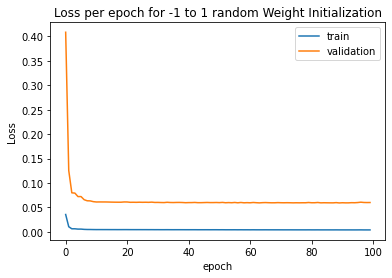

In [111]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(100)],[np.mean(Train_loss[i:i+1]) for i in range(100)],label="train")
plt.plot([i for i in range(100)],[np.mean(valid_loss[i:i+1]) for i in range(100)],label="validation")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch for -1 to 1 random Weight Initialization")
plt.legend()
plt.show()

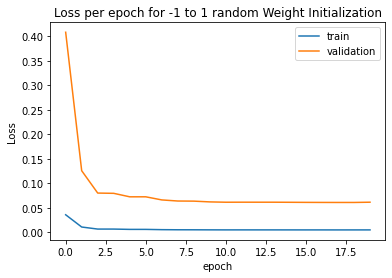

In [112]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(20)],[np.mean(Train_loss[i:i+1]) for i in range(20)],label="train")
plt.plot([i for i in range(20)],[np.mean(valid_loss[i:i+1]) for i in range(20)],label="validation")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch for -1 to 1 random Weight Initialization")
plt.legend()
plt.show()

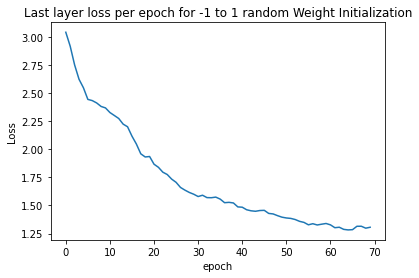

In [113]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(70)],[np.mean(loss_Total[i:i+30]) for i in range(70)])
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Last layer loss per epoch for -1 to 1 random Weight Initialization")
plt.show()

He Weight Initialization:

In [114]:
def creat_minibatch(data,label,batch_size):
    #print(np.shape(data))
    #print(np.shape(label))
    merged = np.c_[ data, label ] 
    np.random.shuffle(merged)
    #print(np.shape(merged))
    batchX = []
    batchy = []
    i = 0
    while i < len(merged):
        x = merged[i:i+batch_size,0:len(merged[0])-1]
        y = merged[i:i+batch_size,-1]
        batchX.append(x)
        batchy.append(y)
        i = i + batch_size
    #print(batchX)
    #print(batchy)
    return batchX, batchy
#creat_minibatch([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]],[1,2,3,4,5,6,7,8],4)

class LReLU():
    def __init__(self):
        return
    
    def forward(self,Z): #input, output = [batch,neuroncount]
        return np.array(Z>=0).astype(int) * Z + np.array(Z<0).astype(int) * Z * 0.01
    def backward(self,Z,dz):
        return np.array(Z>=0).astype(int)*dz + np.array(Z<0).astype(int) * 0.01 * dz
    
class Dense():
    def __init__(self,input,neuron,lr):
        self.neuroncount = neuron
        self.inputcount = input
        self.lr = lr
        #self.W =  np.random.randn(input,neuron)
        #self.W = np.random.normal(loc=0.0,scale=np.sqrt(2/(input+neuron)),size=(input,neuron))
        #self.W = np.zeros((input,neuron))
        self.b = np.zeros(neuron).astype(float)#(batch_size,neuron)
        self.W = np.random.normal(loc=0.0,scale=np.sqrt(2.0 /input),size=(input,neuron))
        self.delta_w = 0
    
    def forward(self,X):#X=(inputcount,batch)
        return np.dot(X,self.W) + self.b
    def backward(self,X,din):
        W = np.copy(self.W)
        #print(np.shape(X))
        #print(np.shape(gradiant))
        dw = np.dot(X.T, din.astype(float))
        self.W = self.W - self.lr * dw + 0.9*self.delta_w
        self.delta_w = - self.lr * dw + 0.9*self.delta_w
        db = np.sum(din,axis = 0)
        self.b = self.b - self.lr * db
        return np.dot(din, W.T)

class costFunction:
    def __init__(self):
        return
    def L2(self,yp,y):
        m = len(y)
        return np.sum(((np.array(yp)-np.array(y.reshape((len(y),1))))*(np.array(yp)-np.array(y.reshape((len(y),1))))),axis = 1,keepdims=True)/m/2#np.ones(ans.shape)
    def dloss(self,yp,y):
        m = len(y)
        return np.sum(np.array(yp)-np.array(y.reshape((len(y),1))),axis = 1, keepdims=True)/m#np.ones(ans.shape)
class Network:
    def __init__(self):
        self.net = []
    def add_Dense(self, shape,lr):
        self.net.append(Dense(shape[0],shape[1],lr))
    def add_LReLU(self):
        self.net.append(LReLU())
    def predict(self,X):
        out = np.copy(X)
        for layer in self.net:
            out = layer.forward(out)
        return out
    def train(self,X,y):
        cf = costFunction()
        inputs = []
        inputs.append(X)
        input = np.copy(X)
        for l in self.net:
            input = l.forward(input)
            inputs.append(input)
        yp = input
        
        loss = cf.L2(yp,y)
        dloss = cf.dloss(yp,y)

        for i in range(len(self.net)):
            j = len(self.net) - i - 1
            layer = self.net[j]       
            dloss = layer.backward(inputs[j],dloss)
        return np.mean(loss)


network = Network()
network.add_Dense((128,10),0.001)
network.add_LReLU()
network.add_Dense((10,10),0.001)
network.add_LReLU()
network.add_Dense((10,10),0.001)
network.add_LReLU()
network.add_Dense((10,1),0.001)
network.add_LReLU()
batch_size = 128
loss_Total = []
Train_loss = []
valid_loss = []
cf = costFunction()
Train_loss.append(np.mean(cf.L2(network.predict(data.train_imgs),np.array(train_label))))
valid_loss.append(np.mean(cf.L2(network.predict(data.valid_imgs),np.array(valid_label))))
for epoch in range(100):
    batchX, batchy = creat_minibatch(data.train_imgs,train_label,batch_size)#diabetes_X,diabetes_y
    l1 = []
    l2 = []
    i = 0
    for (x_batch,y_batch) in zip(batchX, batchy):
        if np.shape(x_batch)[0] != batch_size:
            break
        loss_Total.append(network.train(np.array(x_batch).astype(float),y_batch))
        if i % 10 == 1:
            l1.append(np.mean(cf.L2(network.predict(data.train_imgs),np.array(train_label))))
            l2.append(np.mean(cf.L2(network.predict(data.valid_imgs),np.array(valid_label))))
        i = i + 1
        print(loss_Total[-1])
    for l in [0,2,4,6]:
        if network.net[l].lr > 0.0001:
            network.net[l].lr = network.net[l].lr - 0.0001
    print(epoch)   
    Train_loss.append(np.mean(l1))
    valid_loss.append(np.mean(l2))
print("Test RMSE:")
print(np.sqrt(np.mean((network.predict(data.test_imgs)-test_label)**2)))

Streaming output truncated to the last 5000 lines.
0.5826713642972627
0.6438092206967538
0.6283182249430803
0.580493857060693
0.5310637395736522
0.6316268246568377
0.7324005469455119
0.6175491468575947
0.6679175030442301
0.4885009219492237
0.7996969774198777
0.5447437840684134
0.6328976941553028
0.5031035355383229
0.7701739163615017
0.7317193520366936
0.5366239287080441
0.6611935906804705
0.7447724370990156
0.6132751261217322
0.6691053365165274
0.575104133668347
0.5270495322179151
0.5793242456381071
0.6600285022341105
0.47526080207289206
0.5519574196482981
0.672716685671339
0.8438907394631285
0.42307378234453014
0.4434681674022242
0.901973861878639
0.656601657618076
0.6840893186189719
0.6599583584093159
0.6662071534859426
0.5836111354958612
0.6592741258446485
0.548919568566484
0.575946559226931
0.8656887575948069
0.7803072928345818
0.7809785037295073
0.5743296053689009
0.6838273423247693
0.8474116295665436
0.6192410269700899
0.7667387412434954
0.8059271707634243
0.6095953527412772
0.58

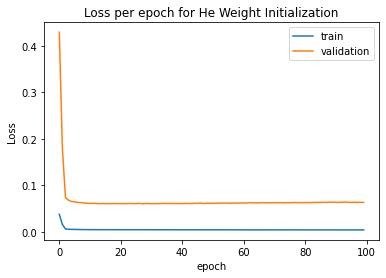

In [115]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(100)],[np.mean(Train_loss[i:i+1]) for i in range(100)],label="train")
plt.plot([i for i in range(100)],[np.mean(valid_loss[i:i+1]) for i in range(100)],label="validation")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch for He Weight Initialization")
plt.legend()
plt.show()

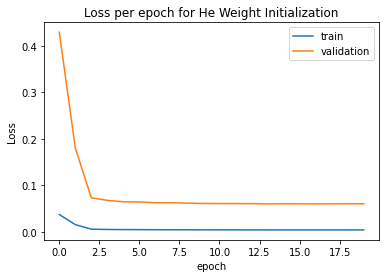

In [120]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(20)],[np.mean(Train_loss[i:i+1]) for i in range(20)],label="train")
plt.plot([i for i in range(20)],[np.mean(valid_loss[i:i+1]) for i in range(20)],label="validation")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch for He Weight Initialization")
plt.legend()
plt.show()

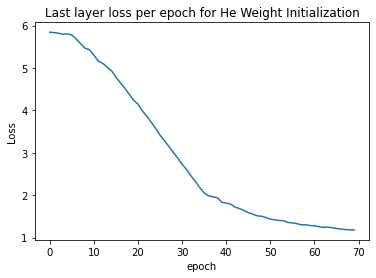

In [117]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(70)],[np.mean(loss_Total[i:i+30]) for i in range(70)])
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Last layer loss per epoch for He Weight Initialization")
plt.show()

STep decay learning rate adaption:

In [121]:
def creat_minibatch(data,label,batch_size):
    #print(np.shape(data))
    #print(np.shape(label))
    merged = np.c_[ data, label ] 
    np.random.shuffle(merged)
    #print(np.shape(merged))
    batchX = []
    batchy = []
    i = 0
    while i < len(merged):
        x = merged[i:i+batch_size,0:len(merged[0])-1]
        y = merged[i:i+batch_size,-1]
        batchX.append(x)
        batchy.append(y)
        i = i + batch_size
    #print(batchX)
    #print(batchy)
    return batchX, batchy
#creat_minibatch([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]],[1,2,3,4,5,6,7,8],4)

class LReLU():
    def __init__(self):
        return
    
    def forward(self,Z): #input, output = [batch,neuroncount]
        return np.array(Z>=0).astype(int) * Z + np.array(Z<0).astype(int) * Z * 0.01
    def backward(self,Z,dz):
        return np.array(Z>=0).astype(int)*dz + np.array(Z<0).astype(int) * 0.01 * dz
    
class Dense():
    def __init__(self,input,neuron,lr):
        self.neuroncount = neuron
        self.inputcount = input
        self.lr = lr
        self.W =  np.random.randn(input,neuron)
        self.W = np.random.normal(loc=0.0,scale=np.sqrt(2/(input+neuron)),size=(input,neuron))
        self.W = np.zeros((input,neuron))
        self.b = np.zeros(neuron).astype(float)#(batch_size,neuron)
        self.delta_w = 0
    
    def forward(self,X):#X=(inputcount,batch)
        return np.dot(X,self.W) + self.b
    def backward(self,X,din):
        W = np.copy(self.W)
        #print(np.shape(X))
        #print(np.shape(gradiant))
        dw = np.dot(X.T, din.astype(float))
        self.W = self.W - self.lr * dw + 0.9*self.delta_w
        self.delta_w = - self.lr * dw + 0.9*self.delta_w
        db = np.sum(din,axis = 0)
        self.b = self.b - self.lr * db
        return np.dot(din, W.T)

class costFunction:
    def __init__(self):
        return
    def L2(self,yp,y):
        m = len(y)
        return np.sum(((np.array(yp)-np.array(y.reshape((len(y),1))))*(np.array(yp)-np.array(y.reshape((len(y),1))))),axis = 1,keepdims=True)/m/2#np.ones(ans.shape)
    def dloss(self,yp,y):
        m = len(y)
        return np.sum(np.array(yp)-np.array(y.reshape((len(y),1))),axis = 1, keepdims=True)/m#np.ones(ans.shape)
class Network:
    def __init__(self):
        self.net = []
    def add_Dense(self, shape,lr):
        self.net.append(Dense(shape[0],shape[1],lr))
    def add_LReLU(self):
        self.net.append(LReLU())
    def predict(self,X):
        out = np.copy(X)
        for layer in self.net:
            out = layer.forward(out)
        return out
    def train(self,X,y):
        cf = costFunction()
        inputs = []
        inputs.append(X)
        input = np.copy(X)
        for l in self.net:
            input = l.forward(input)
            inputs.append(input)
        yp = input
        
        loss = cf.L2(yp,y)
        dloss = cf.dloss(yp,y)

        for i in range(len(self.net)):
            j = len(self.net) - i - 1
            layer = self.net[j]       
            dloss = layer.backward(inputs[j],dloss)
        return np.mean(loss)


network = Network()
network.add_Dense((128,10),0.001)
network.add_LReLU()
network.add_Dense((10,10),0.001)
network.add_LReLU()
network.add_Dense((10,10),0.001)
network.add_LReLU()
network.add_Dense((10,1),0.001)
network.add_LReLU()
batch_size = 128
loss_Total = []
Train_loss = []
valid_loss = []
cf = costFunction()
Train_loss.append(np.mean(cf.L2(network.predict(data.train_imgs),np.array(train_label))))
valid_loss.append(np.mean(cf.L2(network.predict(data.valid_imgs),np.array(valid_label))))
for epoch in range(100):
    batchX, batchy = creat_minibatch(data.train_imgs,train_label,batch_size)#diabetes_X,diabetes_y
    l1 = []
    l2 = []
    i = 0
    for (x_batch,y_batch) in zip(batchX, batchy):
        if np.shape(x_batch)[0] != batch_size:
            break
        loss_Total.append(network.train(np.array(x_batch).astype(float),y_batch))
        if i % 10 == 1:
            l1.append(np.mean(cf.L2(network.predict(data.train_imgs),np.array(train_label))))
            l2.append(np.mean(cf.L2(network.predict(data.valid_imgs),np.array(valid_label))))
        i = i + 1
        print(loss_Total[-1])
    for l in [0,2,4,6]:
        if network.net[l].lr > 0.0001 and epoch%10 == 9 :
            network.net[l].lr = network.net[l].lr/2
    print(epoch)   
    Train_loss.append(np.mean(l1))
    valid_loss.append(np.mean(l2))
print("Test RMSE:")
print(np.sqrt(np.mean((network.predict(data.test_imgs)-test_label)**2)))

Streaming output truncated to the last 5000 lines.
1.9471661367553865
1.2627165004257406
1.593729441632041
1.8785726522410937
1.767731903345993
1.3722832343015954
1.2151502188101035
1.4758109542021014
1.7608274528686825
1.975749355757821
1.7400063469842078
1.3566435723962593
1.5875112782507148
1.7762796225751902
1.773070301439827
1.7427519219829986
1.5817149877519667
1.4308512718631867
1.418701283857858
1.3943572433333862
1.7285943351858457
1.6890649975541172
1.3355114184559018
1.4245722216776704
1.3958540719650532
1.591558562597888
1.1972141947875015
1.4097377919145844
1.3810566647138451
1.5928664426117485
1.4273852733296026
1.5237329128267687
1.1365220556259483
1.5293613679372071
1.6778730332179914
1.6335089767199387
1.335225139913935
1.2870731043628334
1.6977068575583942
1.4988123239053206
1.504892631282016
1.7799039855050076
1.5342003844924241
1.6994980427441198
1.5792752312896001
1.4670499738150637
1.329502228337432
1.3622993879502632
2.0557598658475285
1.6019339544242648
1.453697

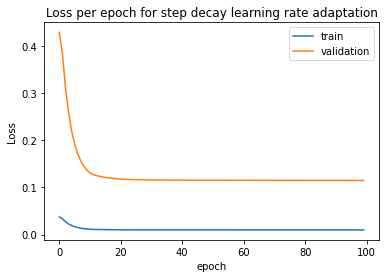

In [122]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(100)],[np.mean(Train_loss[i:i+1]) for i in range(100)],label="train")
plt.plot([i for i in range(100)],[np.mean(valid_loss[i:i+1]) for i in range(100)],label="validation")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch for step decay learning rate adaptation")
plt.legend()
plt.show()

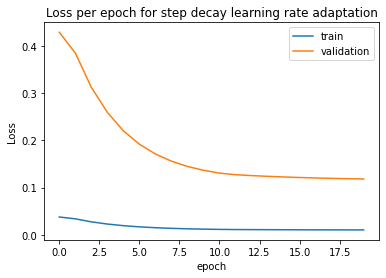

In [127]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(20)],[np.mean(Train_loss[i:i+1]) for i in range(20)],label="train")
plt.plot([i for i in range(20)],[np.mean(valid_loss[i:i+1]) for i in range(20)],label="validation")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch for step decay learning rate adaptation")
plt.legend()
plt.show()

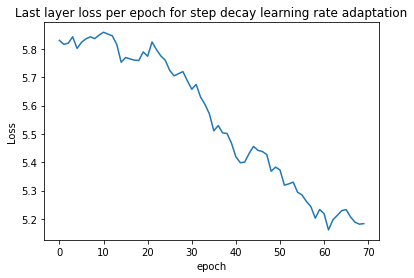

In [124]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(70)],[np.mean(loss_Total[i:i+30]) for i in range(70)])
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Last layer loss per epoch for step decay learning rate adaptation")
plt.show()

### Part B

In [10]:
for l in range(len(data.train_labels)):
  if len(data.train_labels[l])!=3:
    data.train_labels[l] = [data.train_labels[l][0],data.train_labels[l][1],0]

In [11]:
train_label = np.zeros((len(data.train_labels),5))
valid_label = np.zeros((len(data.valid_labels),5)) 
test_label = np.zeros((len(data.test_labels),5)) 
for l in range(len(data.train_labels)):
    train_label[l][int(data.train_labels[l][2])] = 1
for l in range(len(data.valid_labels)):
    valid_label[l][int(data.valid_labels[l][2])] = 1
for l in range(len(data.test_labels)):
    test_label[l][int(data.test_labels[l][2])] = 1

In [142]:
def creat_minibatch(data,label,batch_size):
    #print(np.shape(data))
    #print(np.shape(label))
    y_size = len(label[0])
    merged = np.c_[ data, label ] 
    np.random.shuffle(merged)
    #print(np.shape(merged))
    batchX = []
    batchy = []
    i = 0
    while i < len(merged):
        x = merged[i:i+batch_size,0:128]
        y = merged[i:i+batch_size,-5:]
        batchX.append(x)
        batchy.append(y)
        i = i + batch_size
    #print(batchX)
    #print(batchy)
    return batchX, batchy
#creat_minibatch([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]],[1,2,3,4,5,6,7,8],4)
class Softmax():
    def __init__(self):
        return
    def forward(self,Z): #input, output = [batch,neuroncount]
        ex = np.exp(Z- np.max(Z,axis = 1,keepdims = True))
        return ex / ex.sum(axis=1, keepdims=True)
    def backward(self,Z,dz):
        return dz*( 1-Z)*Z#*self.forward(Z)*(np.eye(np.shape(Z)[0],np.shape(Z)[1])- self.forward(Z))#Z*(np.eye(np.shape(Z)[0],np.shape(Z)[1])- Z)#self.forward(Z)*(np.eye(np.shape(Z)[0],np.shape(Z)[1])- self.forward(Z))*dz#sigmoid(Z)*(1-sigmoid(Z))*dz
class LReLU():
    def __init__(self):
        return
    
    def forward(self,Z): #input, output = [batch,neuroncount]
        return np.array(Z>=0).astype(int) * Z + np.array(Z<0).astype(int) * Z * 0.01
    def backward(self,Z,dz):
        return np.array(Z>=0).astype(int) + np.array(Z<0).astype(int) * 0.01
    
class Dense():
    def __init__(self,input,neuron,lr):
        self.neuroncount = neuron
        self.inputcount = input
        self.lr = lr
        self.W =  np.random.randn(input,neuron)
        self.W = np.random.normal(loc=0.0,scale=0.01,size=(input,neuron))#np.sqrt(2/(input+neuron))
        #self.W = np.zeros((input,neuron))
        self.b = np.zeros(neuron).astype(float)#(batch_size,neuron)
        self.delta_w = 0
    
    def forward(self,X):#X=(inputcount,batch)
        return np.dot(X,self.W) + self.b
    def backward(self,X,gradiant):
        W = np.copy(self.W)
        #update weights and bias:
        #print(np.shape(X))
        #print(np.shape(gradiant))
        dw = np.dot(X.T, gradiant.astype(float))
        self.delta_w = - self.lr * dw + 0.9*self.delta_w
        self.W = self.W + self.delta_w
        db = np.sum(gradiant,axis = 0)
        self.b = self.b - self.lr * db
        return np.dot(gradiant, W.T)

class costFunction:
    def __init__(self):
        return
    def L2(self,yp,y):
        ans = np.sum(yp.astype(float)-y.astype(float),axis=1)*np.sum(yp.astype(float)-y.astype(float),axis=1)
        return np.sum(((yp-y)*(yp-y)),axis = 1,keepdims = True)/batch_size/2#np.ones(ans.shape)
    def dloss(self,yp,y):
        ans = np.sum(yp.astype(float)-y.astype(float),axis=1, keepdims = True)
        return np.sum((yp-y),axis = 1, keepdims = True)/batch_size#np.ones(ans.shape)
class NegLog:
    def __init__(self):
        return
    def neg_log(self,yp,y):
        
        return np.sum(-1*y*np.log(yp),axis = 1,keepdims=True)
    def dneg_log(self,yp,y):
        return - 1/len(y) * y / (yp+ 0.01*np.array(yp==0).astype(int))
class Network:
    def __init__(self):
        self.net = []
    def add_Dense(self, shape,lr):
        self.net.append(Dense(shape[0],shape[1],lr))
    def add_LReLU(self):
        self.net.append(LReLU())
    def add_softmax(self):
        self.net.append(Softmax())
    def predict(self,X):
        out = np.copy(X)
        for layer in self.net:
            out = layer.forward(out)
        return out
    def train(self,X,y):
        cf = NegLog()
        inputs = []
        inputs.append(X)
        input = np.copy(X)
        for l in self.net:
            input = l.forward(input)
            inputs.append(input)
        yp = input
        loss = cf.neg_log(yp,y)
        dloss = cf.dneg_log(yp,y)

        for i in range(len(self.net)):
            j = len(self.net) - i - 1
            layer = self.net[j]       
            dloss = layer.backward(inputs[j],dloss)
        return np.mean(loss)


network = Network()
network.add_Dense((128,10),0.001)
network.add_LReLU()
network.add_Dense((10,10),0.001)
network.add_LReLU()
network.add_Dense((10,10),0.001)
network.add_LReLU()
network.add_Dense((10,5),0.001)
network.add_softmax()
batch_size = 128
loss_Total = []
Train_loss = []
valid_loss = []
Train_acc = []
valid_acc= []
cf = NegLog()
ltr = [int(x[2]) for x in data.train_labels]
lv = [int(x[2]) for x in data.valid_labels]
lt = [int(x[2]) for x in data.test_labels]

Train_loss.append(np.mean(cf.neg_log(network.predict(data.train_imgs),np.array(train_label))))
valid_loss.append(np.mean(cf.neg_log(network.predict(data.valid_imgs),np.array(valid_label))))
Train_acc.append(np.sum(np.array(np.argmax(network.predict(data.train_imgs),axis = 1)==np.array(ltr)).astype(int))/len(ltr))
valid_acc.append(np.sum(np.array(np.argmax(network.predict(data.valid_imgs),axis = 1)==np.array(lv)).astype(int))/len(lv))
for epoch in range(100):
    batchX, batchy = creat_minibatch(data.train_imgs,train_label,batch_size)#diabetes_X,diabetes_y
    l1 = []
    l2 = []
    i = 0
    for (x_batch,y_batch) in zip(batchX, batchy):
        if np.shape(x_batch)[0] != batch_size:
            break
        loss_Total.append(network.train(np.array(x_batch).astype(float),y_batch))
        if i % 10 == 0:
            l1.append(np.mean(cf.neg_log(network.predict(data.train_imgs),np.array(train_label))))
            l2.append(np.mean(cf.neg_log(network.predict(data.valid_imgs),np.array(valid_label))))
            
        i = i + 1
        print(loss_Total[-1])
    for l in [0,2,4,6]:
        if network.net[l].lr > 0.00001 and epoch%10 == 9:
            network.net[l].lr = network.net[l].lr/2
    print(epoch)   
    Train_loss.append(np.mean(l1))
    valid_loss.append(np.mean(l2))
    Train_acc.append(np.sum(np.array(np.argmax(network.predict(data.train_imgs),axis = 1)==np.array(ltr)).astype(int))/len(ltr))
    valid_acc.append(np.sum(np.array(np.argmax(network.predict(data.valid_imgs),axis = 1)==np.array(lv)).astype(int))/len(lv))
print("Test acc:")
print(np.sum(np.array(np.argmax(network.predict(data.test_imgs),axis = 1)==np.array(lt)).astype(int))/len(lt))

Streaming output truncated to the last 5000 lines.
1.5660594510305619
1.5427178585845251
1.5533359453144222
1.5620675077099921
1.548150249039085
1.547002788791072
1.551013203043281
1.5755372211832441
1.5694662692881374
1.5357733375792468
1.5614808357785765
1.5693184018494437
1.560038267632335
1.558144288503857
1.5620099002433423
1.5689744386775555
1.5577040376187183
1.5562885243594573
1.5485578820667514
1.5643213801586302
1.5593204050166471
1.557011911580687
1.5540960339090653
1.5599523541571623
1.5464117033271796
1.5526595233507547
1.5585939892568936
1.572403735875305
1.5625310052575325
1.5680416831348314
1.5567761195972754
1.550186659315075
1.5523097526914738
1.5663591034173137
1.5624900926483316
1.5538859099631543
1.5856555465543962
1.558972224665816
1.5604978781312877
1.5408575971408063
1.5507375247459432
1.573003812058626
1.5612284708241124
1.5488482134732506
1.5606278761143937
1.5683589632839572
1.5644269173811984
1.5525968629750557
1.5424507102365983
1.568483869820663
1.54041177

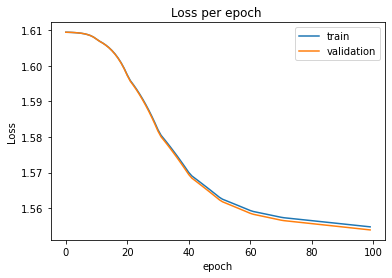

In [143]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(100)],[np.mean(Train_loss[i:i+1]) for i in range(100)],label="train")
plt.plot([i for i in range(100)],[np.mean(valid_loss[i:i+1]) for i in range(100)],label="validation")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch ")
plt.legend()
plt.show()

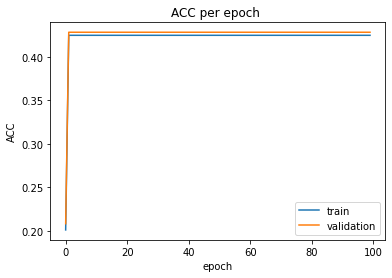

In [146]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(100)],[np.mean(Train_acc[i:i+1]) for i in range(100)],label="train")
plt.plot([i for i in range(100)],[np.mean(valid_acc[i:i+1]) for i in range(100)],label="validation")
plt.xlabel("epoch")
plt.ylabel("ACC")
plt.title("ACC per epoch ")
plt.legend()
plt.show()

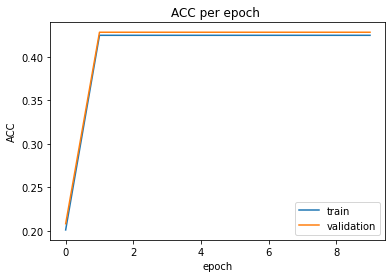

In [147]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(10)],[np.mean(Train_acc[i:i+1]) for i in range(10)],label="train")
plt.plot([i for i in range(10)],[np.mean(valid_acc[i:i+1]) for i in range(10)],label="validation")
plt.xlabel("epoch")
plt.ylabel("ACC")
plt.title("ACC per epoch ")
plt.legend()
plt.show()

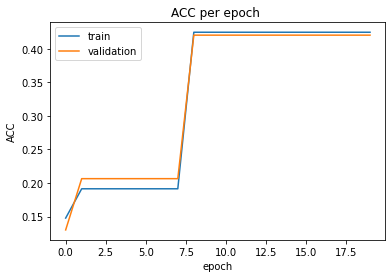

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(20)],[np.mean(Train_acc[i:i+1]) for i in range(20)],label="train")
plt.plot([i for i in range(20)],[np.mean(valid_acc[i:i+1]) for i in range(20)],label="validation")
plt.xlabel("epoch")
plt.ylabel("ACC")
plt.title("ACC per epoch ")
plt.legend()
plt.show()

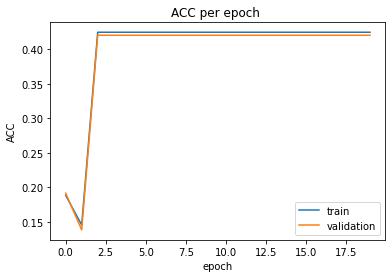

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(20)],[np.mean(Train_acc[i:i+1]) for i in range(20)],label="train")
plt.plot([i for i in range(20)],[np.mean(valid_acc[i:i+1]) for i in range(20)],label="validation")
plt.xlabel("epoch")
plt.ylabel("ACC")
plt.title("ACC per epoch ")
plt.legend()
plt.show()

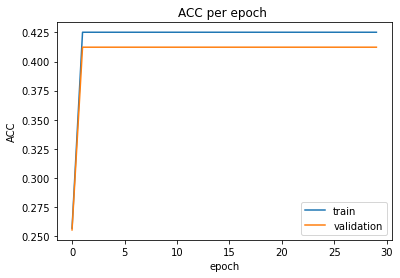

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(30)],[np.mean(Train_acc[i:i+1]) for i in range(30)],label="train")
plt.plot([i for i in range(30)],[np.mean(valid_acc[i:i+1]) for i in range(30)],label="validation")
plt.xlabel("epoch")
plt.ylabel("ACC")
plt.title("ACC per epoch ")
plt.legend()
plt.show()

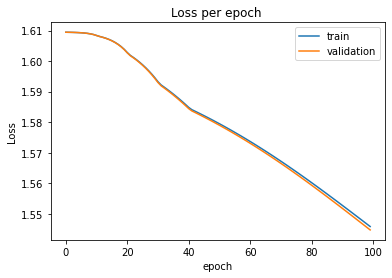

In [135]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(100)],[np.mean(Train_loss[i:i+1]) for i in range(100)],label="train")
plt.plot([i for i in range(100)],[np.mean(valid_loss[i:i+1]) for i in range(100)],label="validation")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch ")
plt.legend()
plt.show()

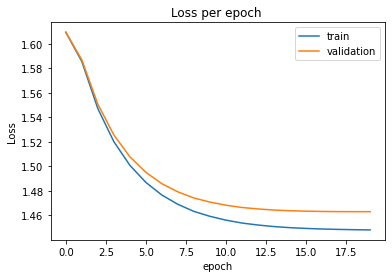

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(20)],[np.mean(Train_loss[i:i+1]) for i in range(20)],label="train")
plt.plot([i for i in range(20)],[np.mean(valid_loss[i:i+1]) for i in range(20)],label="validation")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch ")
plt.legend()
plt.show()

### Part C

Set labels:

In [6]:
train_label = [int(l[1]) for l in data.train_labels]
valid_label = [int(l[1]) for l in data.valid_labels]
test_label = [int(l[1]) for l in data.test_labels]

In [44]:
def creat_minibatch(data,label,batch_size):
    #print(np.shape(data))
    #print(np.shape(label))
    merged = np.c_[ data, label ] 
    np.random.shuffle(merged)
    #print(np.shape(merged))
    batchX = []
    batchy = []
    i = 0
    while i < len(merged):
        x = merged[i:i+batch_size,0:len(merged[0])-1]
        y = merged[i:i+batch_size,-1]
        batchX.append(x)
        batchy.append(y)
        i = i + batch_size
    #print(batchX)
    #print(batchy)
    return batchX, batchy
#creat_minibatch([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]],[1,2,3,4,5,6,7,8],4)

class LReLU():
    def __init__(self):
        return
    
    def forward(self,Z): #input, output = [batch,neuroncount]
        return np.array(Z>=0).astype(int) * Z + np.array(Z<0).astype(int) * Z * 0.01
    def backward(self,Z,dz):
        return np.array(Z>=0).astype(int)*dz + np.array(Z<0).astype(int) * 0.01 * dz
    
class Sigmoid():
    def __init__(self):
        return
    def forward(self,Z): #input, output = [batch,neuroncount]
        return  1 / (1 + np.exp(-1*np.array(Z)))
    def backward(self,Z,dz):
        return dz*( 1-1 / (1 + np.exp(-1*np.array(Z))))*1 / (1 + np.exp(-1*np.array(Z)))
class LogLoss:
    def __init__(self):
        return
    def logloss(self,yp,y):
        return np.sum(-1*y*np.log(yp)-1*(1-y)*np.log(1-yp),axis = 1,keepdims=True)/len(y)
    def dlogloss(self,yp,y):
        return - 1/len(y) * y.reshape(-1, 1) / (yp+ 0.01*np.array(yp==0).astype(int)) + 1/len(y) * (1-y).reshape(-1, 1) / (1 - yp+ 0.01*np.array(yp==0).astype(int))

class Dense():
    def __init__(self,input,neuron,lr):
        self.neuroncount = neuron
        self.inputcount = input
        self.lr = lr
        self.W =  np.random.randn(input,neuron)
        self.W = np.random.normal(loc=0.0,scale=np.sqrt(2/(input+neuron)),size=(input,neuron))
        #self.W = np.zeros((input,neuron))
        self.b = np.zeros(neuron).astype(float)#(batch_size,neuron)
        self.delta_w = 0
    
    def forward(self,X):#X=(inputcount,batch)
        return np.dot(X,self.W) + self.b
    def backward(self,X,din):
        W = np.copy(self.W)
        #print(np.shape(X))
        #print(np.shape(gradiant))
        dw = np.dot(X.T, din.astype(float))
        self.W = self.W - self.lr * dw + 0.9*self.delta_w
        self.delta_w = - self.lr * dw + 0.9*self.delta_w
        db = np.sum(din,axis = 0)
        self.b = self.b - self.lr * db
        return np.dot(din, W.T)

class costFunction:
    def __init__(self):
        return
    def L2(self,yp,y):
        m = len(y)
        return np.sum(((np.array(yp)-np.array(y.reshape((len(y),1))))*(np.array(yp)-np.array(y.reshape((len(y),1))))),axis = 1,keepdims=True)/m/2#np.ones(ans.shape)
    def dloss(self,yp,y):
        m = len(y)
        return np.sum(np.array(yp)-np.array(y.reshape((len(y),1))),axis = 1, keepdims=True)/m#np.ones(ans.shape)
class Network:
    def __init__(self):
        self.net = []
    def add_Dense(self, shape,lr):
        self.net.append(Dense(shape[0],shape[1],lr))
    def add_LReLU(self):
        self.net.append(LReLU())
    def add_Sigmoid(self):
        self.net.append(Sigmoid())
    def predict(self,X):
        out = np.copy(X)
        for layer in self.net:
            out = layer.forward(out)
        return out
    def train(self,X,y):
        cf = LogLoss()
        inputs = []
        inputs.append(X)
        input = np.copy(X)
        for l in self.net:
            input = l.forward(input)
            inputs.append(input)
        yp = input
        loss = cf.logloss(yp,y)
        dloss = cf.dlogloss(yp,y)

        for i in range(len(self.net)):
            j = len(self.net) - i - 1
            layer = self.net[j]       
            dloss = layer.backward(inputs[j],dloss)
        return np.mean(loss)


network = Network()
network.add_Dense((128,10),0.001)
network.add_LReLU()
network.add_Dense((10,10),0.001)
network.add_LReLU()
network.add_Dense((10,10),0.001)
network.add_LReLU()
network.add_Dense((10,1),0.001)
network.add_Sigmoid()
batch_size = 128
loss_Total = []
Train_loss = []
valid_loss = []
Train_acc = []
valid_acc = []
cf = LogLoss()
Train_acc.append(np.sum(np.array(np.sign(network.predict(data.train_imgs)-0.5).flatten()==np.array(train_label).flatten()).astype(int))/len(train_label))
valid_acc.append(np.sum(np.array(np.sign(network.predict(data.valid_imgs)-0.5).flatten()==np.array(valid_label).flatten()).astype(int))/len(valid_label))
Train_loss.append(np.mean(cf.logloss(network.predict(data.train_imgs),np.array(train_label))))
valid_loss.append(np.mean(cf.logloss(network.predict(data.valid_imgs),np.array(valid_label))))
for epoch in range(100):
    batchX, batchy = creat_minibatch(data.train_imgs,train_label,batch_size)#diabetes_X,diabetes_y
    l1 = []
    l2 = []
    i = 0
    for (x_batch,y_batch) in zip(batchX, batchy):
        if np.shape(x_batch)[0] != batch_size:
            break
        loss_Total.append(network.train(np.array(x_batch).astype(float),y_batch))
        '''if i % 20 == 21:
            l1.append(np.mean(cf.logloss(network.predict(data.train_imgs),np.array(train_label))))
            l2.append(np.mean(cf.logloss(network.predict(data.valid_imgs),np.array(valid_label))))'''
        i = i + 1
        print(loss_Total[-1])
    for l in [0,2,4,6]:
        if network.net[l].lr > 0.0001:# and epoch%10 == 9 :
            network.net[l].lr = network.net[l].lr - 0.0001
            #network.net[l].lr = network.net[l].lr/2
    print(epoch)   
    Train_loss.append(np.mean(cf.logloss(network.predict(data.train_imgs),np.array(train_label))))
    valid_loss.append(np.mean(np.mean(cf.logloss(network.predict(data.valid_imgs),np.array(valid_label)))))
    Train_acc.append(np.sum(np.array(np.sign(network.predict(data.train_imgs)-0.5).flatten()==np.array(train_label).flatten()).astype(int))/len(train_label))
    valid_acc.append(np.sum(np.array(np.sign(network.predict(data.valid_imgs)-0.5).flatten()==np.array(valid_label).flatten()).astype(int))/len(valid_label))
    print(Train_acc[-1])
    print(valid_acc[-1])
print("Test ACC:")
print(np.sum(np.array(np.sign(network.predict(data.test_imgs)-0.5).flatten()==np.array(test_label).flatten()).astype(int))/len(test_label))

Streaming output truncated to the last 5000 lines.
1.0947033001078115
1.09135196320625
1.0911770349309438
1.0898227009542079
1.1965648848574095
1.1770938160660604
1.1080274352545771
1.0892261071740303
1.0944638175773396
1.141140073733743
1.0869645508674002
1.1253651250989347
1.105690343972775
1.1880487939920377
1.0689136915456703
1.1331608373258832
1.1466668997664633
1.0564654205132396
1.0676699361848319
1.119852535412573
1.0804484350666772
1.1386647886536831
1.0963804068391902
1.1817595263787508
1.1436767553694285
1.1019393248990537
1.1255436559725616
1.1129334110819222
1.120103644840939
1.169081412048822
1.1078105700280498
1.1435162246828217
1.0605114411842629
1.0920231284749573
1.1299653882746856
1.156573988868958
1.0566832782301632
1.1127407744112507
1.1728598944775255
1.1207078921585065
1.1495958909380501
1.1322415241239514
1.0878269891288799
1.1238610953320802
1.1955895022122673
1.168950119616443
1.119678993555974
1.1621194676635629
1.1109773438595165
1.1281775047816827
1.1118109

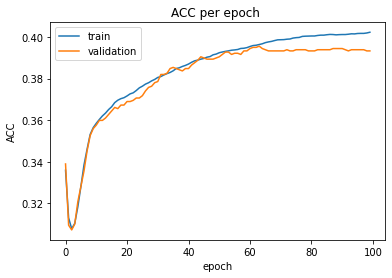

In [46]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(100)],[np.mean(Train_acc[i:i+1]) for i in range(100)],label="train")
plt.plot([i for i in range(100)],[np.mean(valid_acc[i:i+1]) for i in range(100)],label="validation")
plt.xlabel("epoch")
plt.ylabel("ACC")
plt.title("ACC per epoch ")
plt.legend()
plt.show()

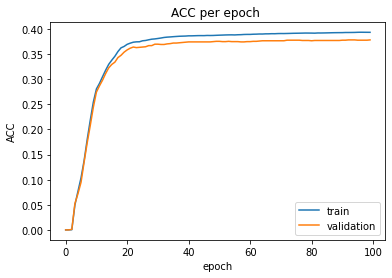

In [14]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(100)],[np.mean(Train_acc[i:i+1]) for i in range(100)],label="train")
plt.plot([i for i in range(100)],[np.mean(valid_acc[i:i+1]) for i in range(100)],label="validation")
plt.xlabel("epoch")
plt.ylabel("ACC")
plt.title("ACC per epoch ")
plt.legend()
plt.show()

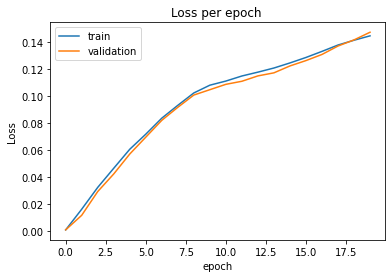

In [43]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(20)],[np.mean(Train_acc[i:i+1]) for i in range(20)],label="train")
plt.plot([i for i in range(20)],[np.mean(valid_acc[i:i+1]) for i in range(20)],label="validation")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch ")
plt.legend()
plt.show()